In [1]:
from skreducedmodel.reducedbasis import ReducedBasis, error, normalize_set
from optuna.samplers import TPESampler
import matplotlib.pyplot as plt
import numpy as np
import optuna 

# Load Data

In [2]:
# physical points
times = np.linspace(-2750, 100, 28501)

# training set
filepath_train = "../../data/1d/1d_200_q_1_to_8.npy"
train = np.load(filepath_train)  
parameters_train = np.linspace(1, 8, train.shape[0])

# validation set
filepath_valid = "../../data/1d/1d_300_q_1_to_8.npy"
valid = np.load(filepath_valid)
valid_normalized = normalize_set(valid, times)
parameters_valid = np.linspace(1, 8, valid.shape[0])

# test set
filepath_test = "../../data/1d/1d_400_q_1_to_8.npy"
test = np.load(filepath_test)
test_normalized = normalize_set(test, times)
parameters_test = np.linspace(1, 8, test.shape[0])

# Optimize

In [3]:
def objective(trial):
    lmax = trial.suggest_int("lmax", 0, 5)
    nmax = trial.suggest_int("nmax", 5, 15)
    seed = trial.suggest_int("seed", 0, train.shape[0]-1)
        
    # build a reduced basis
    rb = ReducedBasis(index_seed_global_rb=seed, lmax=lmax, nmax=nmax)
    rb.fit(train, parameters_train, times)
    
    projections = []
    for h_t, q_t in zip(valid, parameters_valid):
        projections.append(rb.transform(h_t, q_t))
    projections = np.asarray(projections)
    errors = []

    for h_proy, h_valid in zip(projections, valid):
        errors.append(error(h_proy, h_valid, times))
    return max(errors)

In [4]:
# If the optimization is already done, don't do it again
try:
    study = optuna.create_study(study_name=f"1dTPEmv-ts{train.shape[0]}-vs{valid.shape[0]}",
                                storage="sqlite:///studies.db", 
                                load_if_exists=False, 
                                sampler=TPESampler(multivariate=True, seed=12))
except:
    study = optuna.load_study(study_name="1dTPEmv-ts200-vs300",
                                storage="sqlite:///studies.db")
else:
    study.optimize(objective, n_trials=100, gc_after_trial=True)

c:\Users\eliaz\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\samplers\_tpe\sampler.py:282: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2023-05-15 21:06:12,202] A new study created in RDB with name: 1dTPEmv-ts200-vs300
[I 2023-05-15 21:06:16,901] Trial 0 finished with value: 3.1381025680297564e-13 and parameters: {'lmax': 2, 'nmax': 15, 'seed': 146}. Best is trial 0 with value: 3.1381025680297564e-13.
[I 2023-05-15 21:06:20,001] Trial 1 finished with value: 6.8083545286855545 and parameters: {'lmax': 3, 'nmax': 6, 'seed': 31}. Best is trial 0 with value: 3.1381025680297564e-13.
[I 2023-05-15 21:06:22,284] Trial 2 finished with value: 0.0418768219131432 and parameters: {'lmax': 0, 'nmax': 14, 'seed': 120}. Best is trial 0 with value: 3.1381025680297564e-13.
[I 2023-05-15 21:06:25,010] Trial 3 finished with value: 2.8306790464984966 and parameters: {'lmax': 4, 'nmax': 5, 'seed': 193

# Best hyperparameters Found

In [ ]:
best_params = study.best_params; 
for param, value in best_params.items():
    print(f"Best {param} = {value}") 
    # the best seed is an index
print(f"Best Validation Error {study.best_value:.3e}")

Best lmax = 0
Best nmax = 20
Best seed = 141
Best Validation Error 1.532e-08


### Test Error

In [ ]:
test_rb = ReducedBasis(index_seed_global_rb=best_params["seed"], 
                       lmax=best_params["lmax"], 
                       nmax=best_params["nmax"])
test_rb.fit(train, parameters_train, times)
projection_test = test_rb.transform(test, parameters_test)
test_errors = error(projection_test, test, times)

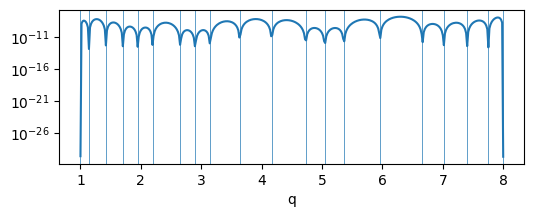

In [ ]:
plt.figure(figsize=(6,2))
plt.plot(parameters_test, test_errors)
plt.yscale("log")

plt.xlabel("q")

for leaf in test_rb.tree.leaves:
    for p in leaf.indices:
        plt.axvline(parameters_train[p],lw=.5)

# Visualize Optimization Results

### Hyperparameter Importances

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
# dataframe with trials
db = study.trials_dataframe()

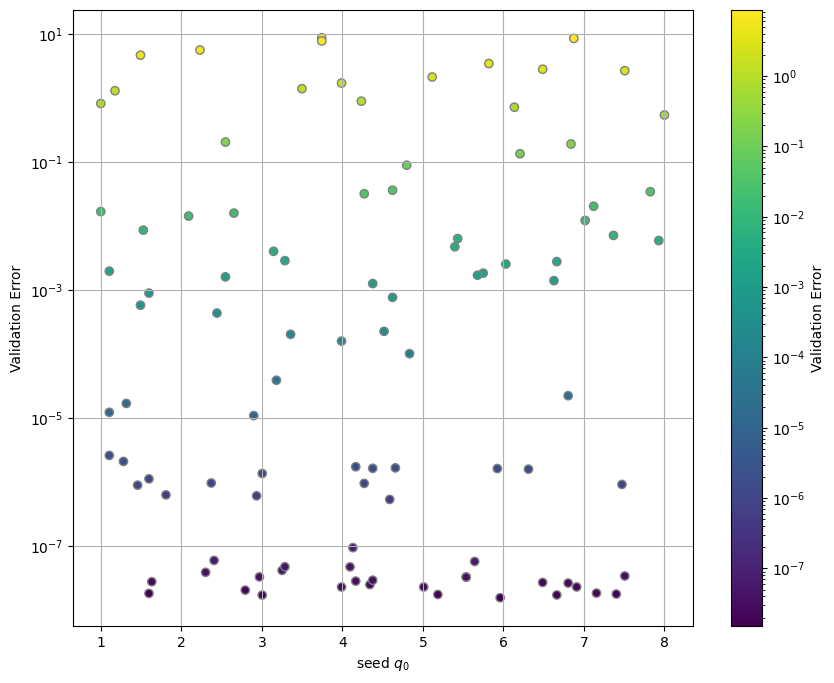

In [ ]:
# seed
from matplotlib import colors

x = parameters_train[db.params_seed]
y = db.value

norm = colors.LogNorm(min(db.value), max(db.value))
plt.figure(figsize=(10, 8))
plt.scatter(x, y, c= db.value, edgecolors="gray",norm=norm)
plt.grid()
plt.colorbar(label="Validation Error")
plt.xlabel(r"seed $q_0$")
plt.ylabel(r"Validation Error")
plt.yscale("log")

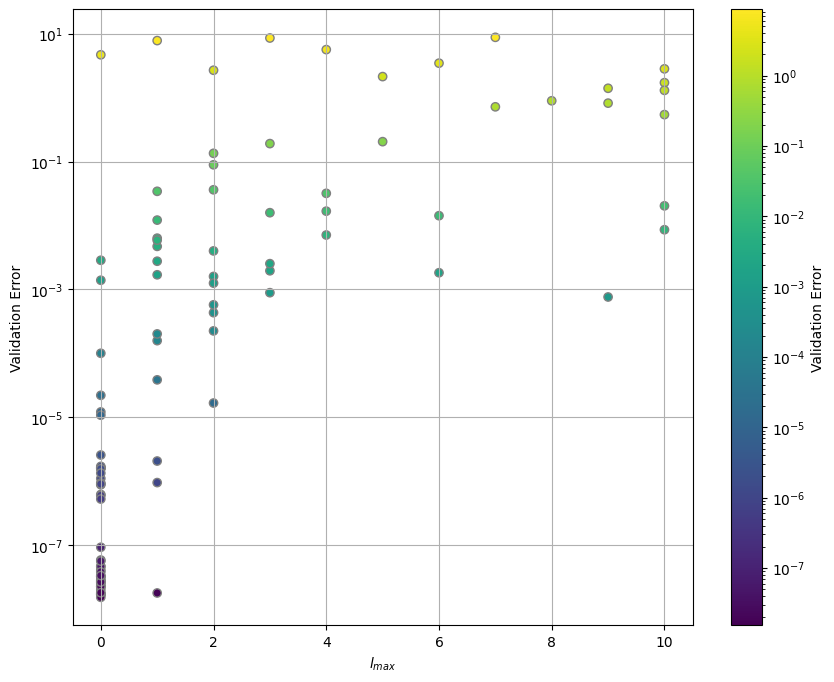

In [ ]:
# seed
from matplotlib import colors

x = db.params_lmax
y = db.value

norm = colors.LogNorm(min(db.value), max(db.value))
plt.figure(figsize=(10, 8))
plt.scatter(x, y, c= db.value, edgecolors="gray",norm=norm)
plt.grid()
plt.colorbar(label="Validation Error")
plt.xlabel(r"$l_{max}$")
plt.ylabel(r"Validation Error")
plt.yscale("log")

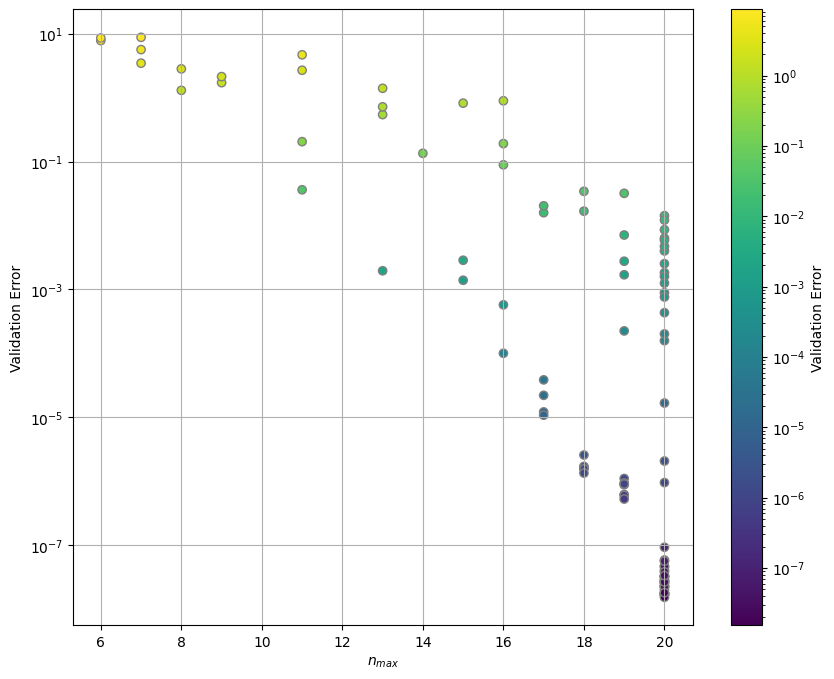

In [ ]:
# seed
from matplotlib import colors

x = db.params_nmax
y = db.value

norm = colors.LogNorm(min(db.value), max(db.value))
plt.figure(figsize=(10, 8))
plt.scatter(x, y, c= db.value, edgecolors="gray",norm=norm)
plt.grid()
plt.colorbar(label="Validation Error")
plt.xlabel(r"$n_{max}$")
plt.ylabel(r"Validation Error")
plt.yscale("log")

### Evolution of Validation Error

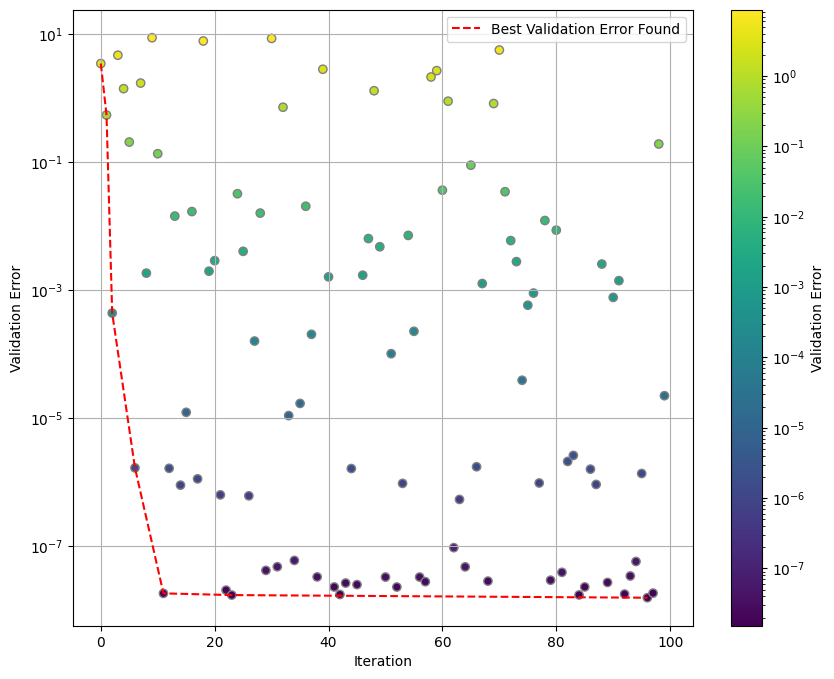

In [ ]:
from matplotlib import colors

x = db.number
y = db.value

min_errs = [y[0]]
min_errs_it = [x[0]]
for i, err in enumerate(y):
    if err <= min(min_errs):
        min_errs.append(err)
        min_errs_it.append(x[i])

norm = colors.LogNorm(y.min(), y.max())
plt.figure(figsize=(10, 8))
plt.scatter(x, y, c=y, edgecolors="gray",norm=norm)
plt.plot(min_errs_it, min_errs, "r--", label="Best Validation Error Found")
plt.grid()
plt.colorbar(label="Validation Error")
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Validation Error")
plt.legend()

### Evolution of Hyperparameters

Text(0, 0.5, '$l_{max}$')

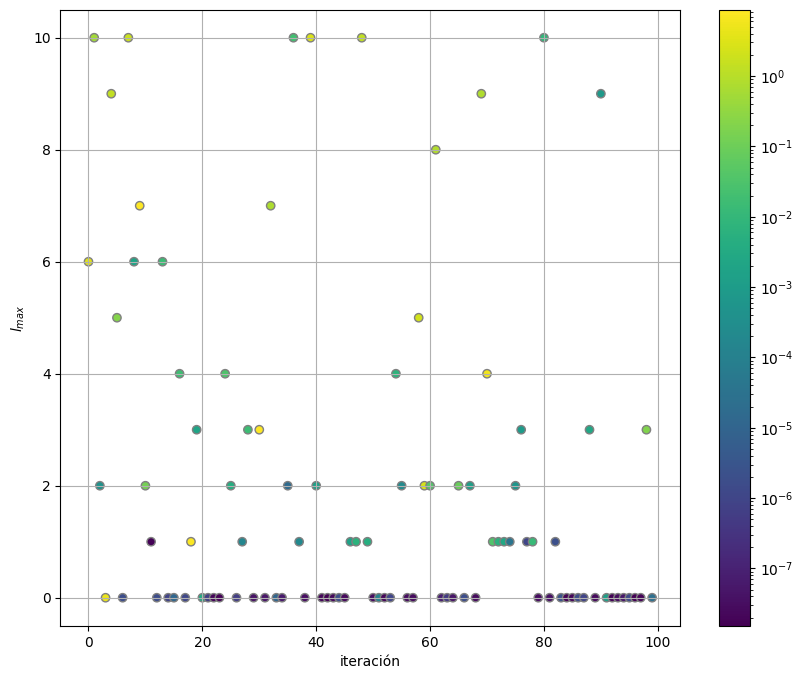

In [ ]:
# lmax
x = db.number
y = db.params_lmax

norm = colors.LogNorm(min(db.value), max(db.value))
plt.figure(figsize=(10, 8))
plt.scatter(x, y, c= db.value, edgecolors="gray",norm=norm)
plt.grid()
plt.colorbar()
plt.xlabel("iteración")
plt.ylabel(r"$l_{max}$")

Text(0, 0.5, '$n_{max}$')

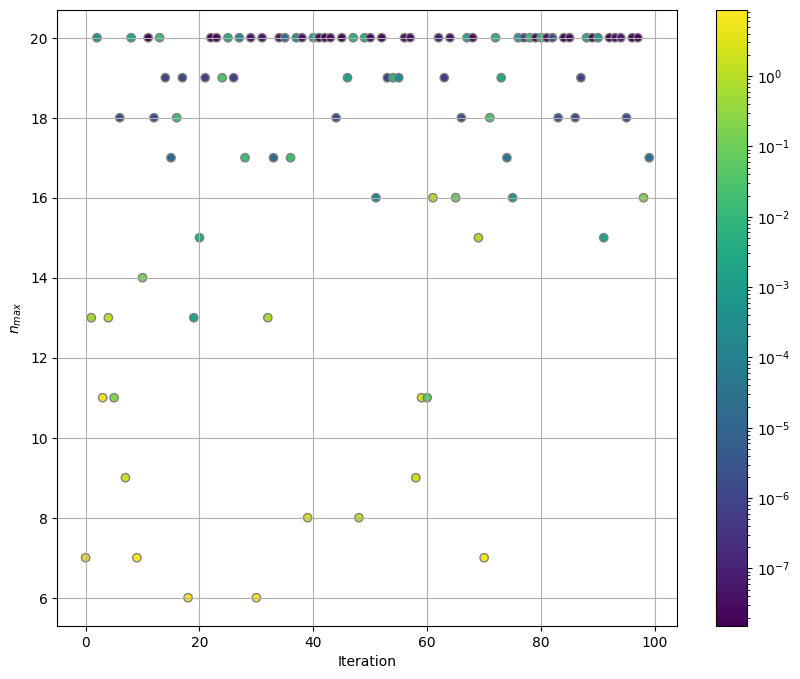

In [ ]:
# n max
x = db.number
y = db.params_nmax

norm = colors.LogNorm(min(db.value), max(db.value))
plt.figure(figsize=(10, 8))
plt.scatter(x, y, c= db.value, edgecolors="gray",norm=norm)
plt.grid()
plt.colorbar()
plt.xlabel("Iteration")
plt.ylabel(r"$n_{max}$")

Text(0, 0.5, 'seed $q_0$')

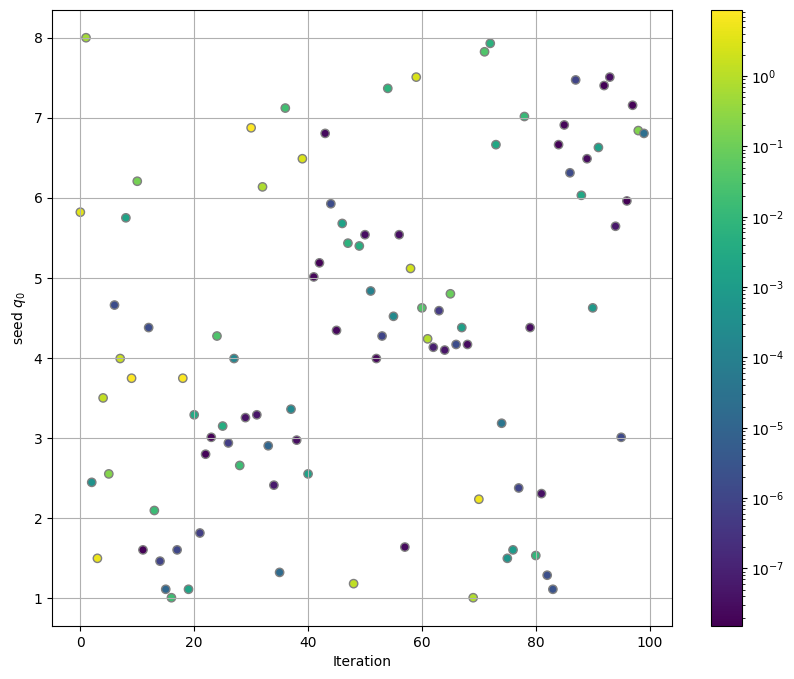

In [ ]:
# seed q0
x = db.number
y = parameters_train[db.params_seed]

norm = colors.LogNorm(min(db.value), max(db.value))
plt.figure(figsize=(10, 8))
plt.scatter(x, y, c= db.value, edgecolors="gray",norm=norm)
plt.grid()
plt.colorbar()
plt.xlabel("Iteration")
plt.ylabel(r"seed $q_0$")